In this lab you will do the following steps in order:

1. Load a new dataset using ``torchvision dataloader``
2. Perform transfer learning of a pre-trained NN (Neural Network)





Useful resources:

* [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)






Use GPU if available

In [ ]:
import torch  # Import the PyTorch library

# Check if GPU (Graphics Processing Unit) is available for training
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Define the device to use for training based on GPU availability
device = torch.device("cuda:0" if train_on_gpu else "cpu")

# Print the chosen device for training
print(device)


CUDA is available!  Training on GPU ...
cuda:0


Data preparation

In [ ]:
# The ! at the beginning is used to execute shell commands
#download images
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
#download metadata
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar

#extract
# tar is a utility for extracting and archiving files.
# The -x option tells tar to extract files, and the -f specifies the filename to extract.
!tar -xf imdb_crop.tar
!tar -xf imdb_meta.tar

--2024-04-26 13:39:16--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar       100%[===================>]   6.53G  24.2MB/s    in 6m 40s  

2024-04-26 13:45:58 (16.7 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]

--2024-04-26 13:45:58--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22937600 (22M) [application/x-tar]
Saving to: ‘imdb_meta.tar’

imdb_meta

Remove grayscale images

In [ ]:
import glob  # Import library for finding all files matching a pattern
from PIL import Image  # Import library for image processing
import numpy as np  # Import library for numerical operations (not used here)
import os  # Import library for operating system functionalities

# Define a path pattern to search for all jpg images within subdirectories of "/content/imdb_crop"
image_path_pattern = "/content/imdb_crop/*/*.jpg"

# The pattern */*.jpg indicates that it should look for any .jpg files inside any folders within /content/imdb_crop.
# Find all image file paths matching the pattern
image_paths = glob.glob(image_path_pattern) # Using the glob module, this line recover a list of all file paths that match the specified pattern

# Iterate through each image path
for image_path in image_paths:
  # Open the image using Pillow's Image class
  image = Image.open(image_path)

  # Get the number of color channels in the image (e.g., RGB has 3 channels)
  num_channels = len(image.getbands())

  # Check if the image has a different number of channels than expected (likely grayscale or unsupported format)
  if num_channels != 3:
    # If not 3 channels, remove the image file
    os.remove(image_path)
    # print(f"Removed {image_path} (not RGB format)")  # Print statement to show removed files


Define function to convert numeric date to common date format

In [ ]:
from datetime import datetime, timedelta  # Import libraries for date and time manipulation

def datenum_to_datetime(datenum):
  """
  Converts a date represented as a floating-point number (Excel-style) to a Python datetime object.

  Args:
      datenum (float): The date represented as a floating-point number.

  Returns:
      datetime: The converted datetime object (year only if conversion fails).
          If conversion fails due to ValueError, TypeError, or OverflowError,
          returns np.nan.
  """

  try:
    # Extract components from the datenum
    days = datenum % 1  # Extract days (decimal part)
    hours = days % 1 * 24  # Extract hours from remaining decimal part
    minutes = hours % 1 * 60  # Extract minutes from remaining decimal part
    seconds = minutes % 1 * 60  # Extract seconds from remaining decimal part

    # Convert to datetime object with separate day, hour, minute, and second components
    exact_date = (datetime.fromordinal(int(datenum))  # Convert integer part to date
                 + timedelta(days=int(days))  # Add extracted days
                 + timedelta(hours=int(hours))  # Add extracted hours
                 + timedelta(minutes=int(minutes))  # Add extracted minutes
                 + timedelta(seconds=round(seconds)))  # Add extracted seconds (rounded)

    # Adjust for Excel's epoch being different from standard epoch (correct for year)
    exact_date -= timedelta(days=366)

    # Return the year from the converted datetime object
    return exact_date.year

  except (ValueError, TypeError, OverflowError) as e:
    return np.nan  # Return np.nan if conversion fails


Define the [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) class

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import scipy
import torch
import collections

class FacesDataset(Dataset):
      """Face Landmarks dataset.

      This class loads and preprocesses a dataset of face images with corresponding ages.
      It supports train, validation, and test splits.
      """

      def __init__(self, root_dir, transform, split):
        """
        Args:
            root_dir (string): Directory containing the images.
            transform (callable, optional): Transformation to be applied to the images.
            split (string): Split type ("train", "val", or "test").
        """
        self.split=split
        self.root_dir = root_dir
        self.data = self.get_data()  # Load and preprocess data
        total_data_len = int(len(self.data) * 0.5)  # Select small portion of the dataset

        # Randomly shuffle indices for train/val/test split. Each of these sets will contain a random assortment of data
        idx = np.arange(total_data_len) # This array represents the indices of the dataset that WILL be shuffled to randomize the order of data samples.
        np.random.seed(0)
        np.random.shuffle(idx)
        print(f"Shuffled indices (first 5): {idx[:5]}")  # Print first 5 shuffled indices

        # Select data based on split
        if split == "train":
            self.data = self.data[idx[:int(total_data_len * 0.6)]]
        elif split == "val":
            self.data = self.data[idx[int(total_data_len * 0.6):int(total_data_len * 0.8)]]
        else:
            self.data = self.data[idx[int(total_data_len * 0.8):]]

        # Analyze age distribution (uncomment to print)
        # age_distribution = collections.Counter()
        # for i, sample in enumerate(self.data):
        #     age_distribution[sample[1]] += 1
        # print(age_distribution)  # Uncomment to print the Counter object


        self.transform = transform



      def get_data(self):
        """
        Loads and preprocesses data from the IMDB dataset (.MAT file).

        This function performs the following steps:
            1. Loads data from the MAT file using scipy.io.loadmat.
            2. Defines column names for the loaded data.
            3. Converts the loaded data into a dictionary.
            4. Creates a pandas DataFrame for efficient data manipulation.
            5. Prints DataFrame shape and the first few rows (before processing).
            6. Converts date of birth to age using vectorized operations.
            7. Filters images based on face score and presence of a single face.
                - Removes images without a face (face_score != -np.inf).
                - Ensures only one face is present (second_face_score.isna()).
                - Filters based on minimum face score threshold (face_score >= 3.5).
                - Filters for valid age range (0 <= age <= 100).
                - Converts age to integer and drops unnecessary columns.
            8. Constructs full image paths by prepending the root directory.
            9. Filters for images with existing paths using vectorized boolean indexing.
            10. Prints DataFrame shape and the first few rows (after processing).
            11. Returns the preprocessed data as a NumPy array.
        """

        # Load data from MAT file and define column names
        mat_imdb = scipy.io.loadmat('/content/imdb/imdb.mat')
        columns = ["full_path", "dob", "photo_taken", "second_face_score", "face_score"]

        # Convert loaded data into a dictionary
        data_dict = {col: mat_imdb['imdb'][0][0][col][0] for col in columns}

        # Create pandas DataFrame for efficient data manipulation
        df_imdb = pd.DataFrame(data_dict)
        if self.split=="train":
          print("Before processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows

        # Convert date of birth to AGE using vectorized operations
        df_imdb['date_of_birth'] = df_imdb['dob'].apply(datenum_to_datetime)
        df_imdb['age'] = df_imdb['photo_taken'].sub(df_imdb['date_of_birth'])  # Handle potential NaNs

        # Filter images based on face score and presence of a single face
        df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]  # Remove images without a face
        df_imdb = df_imdb[df_imdb['second_face_score'].isna()]  # Ensure only one face is present
        df_imdb = df_imdb[df_imdb['face_score'] >= 3.5]  # Filter based on minimum face score threshold
        df_imdb = df_imdb[(df_imdb['age'] <= 100) & (df_imdb['age'] >= 0)]  # Filter for valid age range
        df_imdb['age'] = df_imdb['age'].apply(lambda x: int(x))  # Convert age to integer
        df_imdb = df_imdb.drop(columns=['date_of_birth', 'dob', 'photo_taken', "second_face_score", "face_score"])  # Remove unnecessary columns

        # Construct full image paths using vectorized operations
        df_imdb['full_path'] = self.root_dir+"/"+ df_imdb['full_path'].apply(lambda x: x[0])

        # Filter for images with existing paths using vectorized boolean indexing
        df_imdb = df_imdb[df_imdb['full_path'].apply(os.path.exists)]

        if self.split=="train":
          print("After processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows

        return df_imdb.to_numpy()  # Return preprocessed data as a NumPy array

      def __len__(self):
        """
        Returns the length of the dataset (number of samples).

        This method overrides the default behavior of `len` for the dataset object.
        It simply returns the length of the internal `data` list, which represents
        the preprocessed data after loading and filtering.
        """
        return len(self.data)

      def __getitem__(self, idx):
        """
        Retrieves a sample (image and corresponding age) at a given index.

        This method overrides the default behavior of indexing for the dataset object.
        It takes an index `idx` and performs the following:
            1. Accesses the image name and age at the specified index from `self.data`.
            2. Opens the image using `Image.open` with the full path constructed by
               combining `self.root_dir` and `img_name`.
            3. Applies the defined transformation (`self.transform`) to the image.
            4. Normalizes the age by dividing by 100.
            5. Creates a dictionary `sample` containing the preprocessed image (`image`)
               and the normalized age as a PyTorch tensor (`torch.tensor(age).float()`).
            6. Returns the constructed `sample` dictionary.
        """
        img_name, age = self.data[idx]
        image = Image.open(os.path.join(self.root_dir, img_name))
        image = self.transform(image)
        age = age / 100

        sample = {'image': image, 'age': torch.tensor(age).float()}
        return sample

Build the train/val/test dataloaders




In [ ]:
import pickle

# Define data transformations (augmentations for training and normalization)
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 32

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("/content/imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("/content/imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("/content/imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")


Train set:
Before processing:
(460723, 5)
                                        full_path     dob  photo_taken  \
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  693726         1968   
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  693726         1970   
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  693726         1968   
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  693726         1968   
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  693726         1968   

   second_face_score  face_score  
0           1.118973    1.459693  
1           1.852008    2.543198  
2           2.985660    3.455579  
3                NaN    1.872117  
4                NaN    1.158766  
After processing:
(71828, 2)
                                            full_path  age
7   /content/imdb_crop/02/nm0000002_rm1363385088_1...   80
15  /content/imdb_crop/02/nm0000002_rm2585828096_1...   82
18  /content/imdb_crop/02/nm0000002_rm2769394176_1...   82
19  /content/imdb_crop/02/nm0000002_rm

2. Define a Neural Network (NN) [Mobilenet](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html#torchvision.models.mobilenet_v2) pretrained on Imagenet.

Replace the last classifier

In [ ]:
import torchvision
import torch.nn as nn

# Define the model architecture (MobileNetV2)
# the model is loaded with weights pre-trained on the ImageNet dataset
net = torchvision.models.googlenet(weights='IMAGENET1K_V1')  # Load pre-trained weights
#print(net)
# Adjust the final classification layer
# MobileNetV2 was originally designed for classifying 1000 different classes in ImageNet.
# Here, the code modifies its classifier to make it suitable for age prediction
num_ftrs = net.fc.in_features  # Get the number of input features for the last layer
net.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
    nn.GELU(),  # GELU activation function
    nn.Linear(512, 32),  # Second linear layer with 32 units
    nn.GELU(),  # GELU activation function
    nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
)

# Move the model to the appropriate device (CPU or GPU)
net.to(device)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
from torchsummary import summary
# Print model summary
summary(net, (3, 256, 256))  # Input shape (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
       BasicConv2d-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
       BasicConv2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 192, 64, 64]         110,592
       BatchNorm2d-9          [-1, 192, 64, 64]             384
      BasicConv2d-10          [-1, 192, 64, 64]               0
        MaxPool2d-11          [-1, 192, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          12,288
      BatchNorm2d-13           [-1, 64, 32, 32]             128
      BasicConv2d-14           [-1, 64,

**Transfer learning**

Train only the last layers

In [ ]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "fc" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters

Unfreezing layer: fc, Parameter shape: torch.Size([512, 1024])
Unfreezing layer: fc, Parameter shape: torch.Size([512])
Unfreezing layer: fc, Parameter shape: torch.Size([32, 512])
Unfreezing layer: fc, Parameter shape: torch.Size([32])
Unfreezing layer: fc, Parameter shape: torch.Size([1, 32])
Unfreezing layer: fc, Parameter shape: torch.Size([1])


Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [ ]:
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 2  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler


**Fine-tuning**

Train the network on the training data performing a validation at the end of each epoch. The evaluation is done using [PLCC](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [SROCC](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

1, [67, 674] loss: 0.1094	PLCC: 0.109	SROCC: 0.161	lr: 0.000994
1, [134, 674] loss: 0.0923	PLCC: 0.386	SROCC: 0.361	lr: 0.000976
1, [201, 674] loss: 0.0885	PLCC: 0.492	SROCC: 0.457	lr: 0.000947
1, [268, 674] loss: 0.0851	PLCC: 0.557	SROCC: 0.486	lr: 0.000907
1, [335, 674] loss: 0.0896	PLCC: 0.468	SROCC: 0.409	lr: 0.000857
1, [402, 674] loss: 0.0866	PLCC: 0.530	SROCC: 0.478	lr: 0.000798
1, [469, 674] loss: 0.0852	PLCC: 0.518	SROCC: 0.462	lr: 0.000733
1, [536, 674] loss: 0.0837	PLCC: 0.577	SROCC: 0.502	lr: 0.000661
1, [603, 674] loss: 0.0843	PLCC: 0.567	SROCC: 0.501	lr: 0.000587
1, [670, 674] loss: 0.0860	PLCC: 0.567	SROCC: 0.511	lr: 0.000510
Validation loss: 0.084109	PLCC: 0.604	SROCC: 0.551


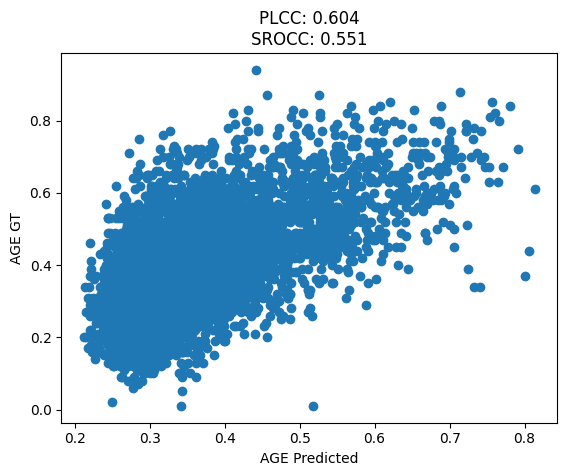

2, [67, 674] loss: 0.0836	PLCC: 0.573	SROCC: 0.504	lr: 0.000428
2, [134, 674] loss: 0.0823	PLCC: 0.594	SROCC: 0.540	lr: 0.000353
2, [201, 674] loss: 0.0824	PLCC: 0.598	SROCC: 0.525	lr: 0.000282
2, [268, 674] loss: 0.0802	PLCC: 0.571	SROCC: 0.526	lr: 0.000216
2, [335, 674] loss: 0.0821	PLCC: 0.599	SROCC: 0.547	lr: 0.000157
2, [402, 674] loss: 0.0835	PLCC: 0.593	SROCC: 0.534	lr: 0.000106
2, [469, 674] loss: 0.0787	PLCC: 0.589	SROCC: 0.537	lr: 0.000065
2, [536, 674] loss: 0.0810	PLCC: 0.592	SROCC: 0.534	lr: 0.000035
2, [603, 674] loss: 0.0809	PLCC: 0.613	SROCC: 0.574	lr: 0.000017
2, [670, 674] loss: 0.0796	PLCC: 0.615	SROCC: 0.554	lr: 0.000010
Validation loss: 0.077054	PLCC: 0.620	SROCC: 0.565


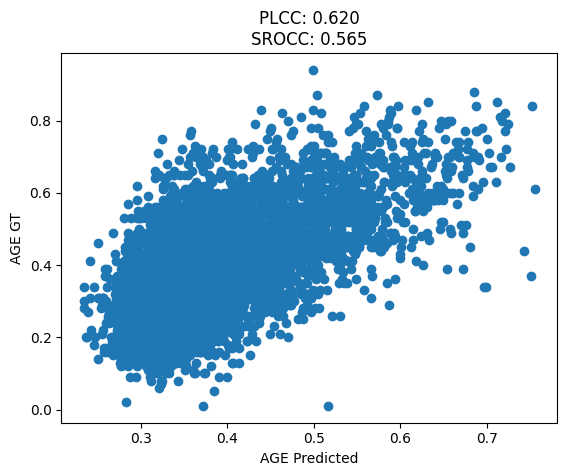

Finished Training


In [ ]:

# Training loop
for epoch in range(epochs):  # Loop over the dataset for multiple epochs
    running_loss = []  # List to store training loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.train()  # Set the model to training mode (enables dropout and other training-specific behaviors)

    for i, data in enumerate(trainloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = net(inputs)  # Get model predictions

        # The squeeze() method is used to remove all dimensions of size 1 from a tensor.
        loss = criterion(outputs.squeeze(), labels)  # Calculate L1 loss between predictions and true labels
        pr_labels.append(outputs.squeeze().detach().cpu())  # Store predictions (detach to avoid gradients)

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(trainloader) // 10) == 0:  # Every 10% of the epoch
            gt_labels = np.stack(list(itertools.chain.from_iterable(gt_labels))).squeeze()  # Combine ground truth labels
            pr_labels = np.stack(list(itertools.chain.from_iterable(pr_labels))).squeeze()  # Combine predictions

            # Calculate and print performance metrics (PLCC, SROCC, learning rate)
            s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
            p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
            print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))

            # Clear lists for next iteration within the epoch
            gt_labels = []
            pr_labels = []
            running_loss = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(valloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = net(inputs)  # Get model predictions without calculating gradients

        pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt_labels = np.stack(gt_labels)  # Combine ground truth labels
    pr_labels = np.stack(pr_labels)  # Combine predictions
    s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
    p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Visualization (optional)
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
    plt.show()

    # Save the model (optional)
    torch.save(net.state_dict(), f"net_last_e{epoch}.pth")  # Save model state after each epoch

print('Finished Training')


Evaluate on the test-set

Test loss: 0.078056	PLCC: 0.634	SROCC: 0.573


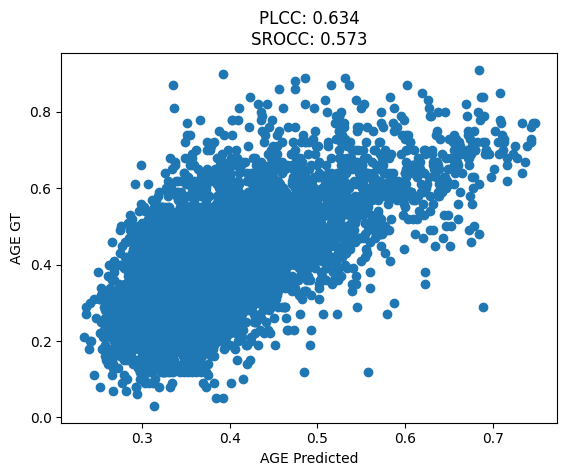

In [ ]:
# Testing loop (after training)
running_loss = []  # List to store test loss for each batch
gt_labels = []  # List to store ground truth labels (predicted age)
pr_labels = []  # List to store predicted labels (model output)

net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

for i, data in enumerate(testloader):
    # Get inputs and labels from the data loader
    inputs, labels = data["image"], data["age"]
    gt_labels.append(labels.item())  # Append ground truth as single values

    inputs = inputs.to(device)  # Move data to the appropriate device
    labels = labels.to(device)  # Move labels to the appropriate device

    # Forward pass with gradient suppression
    with torch.no_grad():
        outputs = net(inputs)  # Get model predictions without calculating gradients

    pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
    loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
    running_loss.append(loss.item())

# Calculate and print test performance metrics
gt_labels = np.stack(gt_labels)  # Combine ground truth labels
pr_labels = np.stack(pr_labels)  # Combine predictions
s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

# Visualization (optional)
plt.scatter(pr_labels, gt_labels)
plt.xlabel("AGE Predicted")
plt.ylabel("AGE GT")
plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
plt.show()


**!ASSIGNMENT!**

*Transfer learning*
1. Finetune all the layers of the current network (mobilenet_v2).
2. Swap out the current model with a new one from [here](https://pytorch.org/vision/main/models.html#classification) that is already trained on Imagenet. Then, fine-tune the network and compare how well it performs on the test-set compared to the current network (mobilenet_v2) using PLCC and SROCC metrics.